In [4]:
from ATT2D_train import *
from shapley import *
from utils import *
from vis_attention import *
from rdkit import Chem

In [6]:
# Load pKa prediction model

reg_model_mat = ATT(multihead_attention=True, return_attention=True)
reg_model_mat_path = "/home/lxy/ATT/best_model_bpka_2d_pre.pth"
reg_model_mat.load_state_dict(torch.load(reg_model_mat_path, map_location=torch.device('cpu')))
print("Load pretrained model")
reg_model_mat.eval()

Load pretrained model


ATT(
  (dropout_layer): Dropout(p=0.1, inplace=False)
  (initial_conv): GATConv(30, 128, heads=4)
  (head_transform1): Linear(in_features=512, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): GATConv(128, 128, heads=4)
  (head_transform2): Linear(in_features=512, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): GATConv(128, 128, heads=4)
  (head_transform3): Linear(in_features=512, out_features=128, bias=True)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): GATConv(128, 128, heads=4)
  (head_transform4): Linear(in_features=512, out_features=128, bias=True)
  (bn4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mhat): MultiAtomAttention(
    (dropout_layer): Dropout(p=0.2, inplace=False)
    (W_a_q): Linear(in_features=128, out_features=1

## Compare attention weights for pKa prediction before and after correction

In [4]:
smiles = "CN1[C@H]2CC[C@@H]1[C@H]([C@H](C2)OC(=O)C3=CC=CC=C3)C(=O)OC"

# Create single input to the model
single_data = create_single_data(smiles)
n_atom = single_data.x.shape[0]

In [5]:
# Extract original multi-head global attention
mol_attention1_before = extract_multi_head_attention(single_data.x, single_data.edge_index, single_data.edge_attr, single_data.batch, reg_model_mat)

# Corrected multi-head global attention
mol_attention1_after = calculate_overall_att(single_data.x, single_data.edge_index, single_data.edge_attr, single_data.batch, reg_model_mat, n_atom)

Main visualization saved to /home/lxy/ToxPred_nitrification-main/img/CN1[C@H]2CC[C@@H]1[C@H]([C@H](C2)OC(=O)C3=CC=CC=C3)C(=O)OC_2d.svg
Colorbar with thick border saved to /home/lxy/ToxPred_nitrification-main/img/CN1[C@H]2CC[C@@H]1[C@H]([C@H](C2)OC(=O)C3=CC=CC=C3)C(=O)OC_c2d.svg


(None,
 tensor([6.6663e+00, 5.5687e+00, 2.2918e-01, 3.6671e-03, 6.1044e-10, 1.4661e+00,
         2.0857e+00, 1.2181e+00, 2.0766e-05, 2.2496e+00, 2.5451e-04, 6.1749e-04,
         1.8475e-06, 8.6752e-01, 7.9782e-03, 7.6060e-01, 7.9782e-03, 8.6752e-01,
         6.5847e-05, 2.2703e-06, 2.8374e-06, 3.8984e-06]))

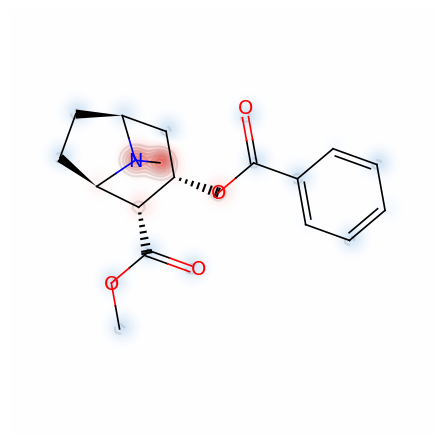

In [17]:
# Before correction
visualize_attention(smiles,mol_attention1_before,output_path='/home/lxy/ATT/img/CN1[C@H]2CC[C@@H]1[C@H]([C@H](C2)OC(=O)C3=CC=CC=C3)C(=O)OC_2d.svg',colorbar_path='/home/lxy/ATT/img/CN1[C@H]2CC[C@@H]1[C@H]([C@H](C2)OC(=O)C3=CC=CC=C3)C(=O)OC_c2d.svg'), mol_attention1_before.sum(axis=0)

Main visualization saved to /home/lxy/ToxPred_nitrification-main/img/CN1[C@H]2CC[C@@H]1[C@H]([C@H](C2)OC(=O)C3=CC=CC=C3)C(=O)OC_2da.svg
Colorbar with thick border saved to /home/lxy/ToxPred_nitrification-main/img/CN1[C@H]2CC[C@@H]1[C@H]([C@H](C2)OC(=O)C3=CC=CC=C3)C(=O)OC_c2da.svg


(None,
 tensor([0.6347, 3.1421, 0.7421, 0.5329, 0.5148, 0.6446, 0.8666, 0.6455, 0.6455,
         1.0798, 1.8064, 0.9614, 1.7185, 1.0062, 0.7691, 0.6086, 0.7691, 1.0062,
         1.2682, 0.9850, 1.3831, 0.2695]))

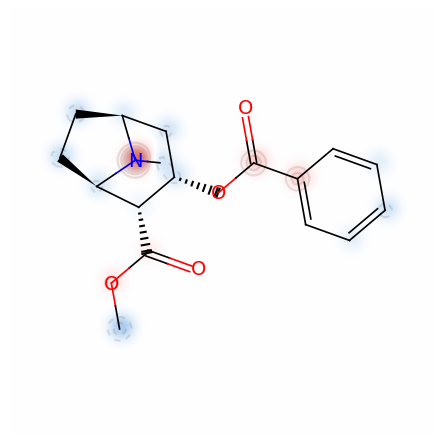

In [7]:
# After correction
visualize_attention(smiles, mol_attention1_after,output_path='/home/lxy/ATT/img/CN1[C@H]2CC[C@@H]1[C@H]([C@H](C2)OC(=O)C3=CC=CC=C3)C(=O)OC_2da.svg',colorbar_path='/home/lxy/ATT/img/CN1[C@H]2CC[C@@H]1[C@H]([C@H](C2)OC(=O)C3=CC=CC=C3)C(=O)OC_c2da.svg'), mol_attention1_after.sum(axis=0)

## Determine the contribution of important susbtructures with Shapley values

In [8]:
smiles = "CN1[C@H]2CC[C@@H]1[C@H]([C@H](C2)OC(=O)C3=CC=CC=C3)C(=O)OC"

# Create single input to the model
single_data = create_single_data(smiles)
n_atom = single_data.x.shape[0]
m = Chem.MolFromSmiles(smiles)

# Corrected attention
corrected_attention = calculate_overall_att(single_data.x, single_data.edge_index, single_data.edge_attr, single_data.batch, reg_model_mat, n_atom)

<Figure size 2400x1800 with 0 Axes>

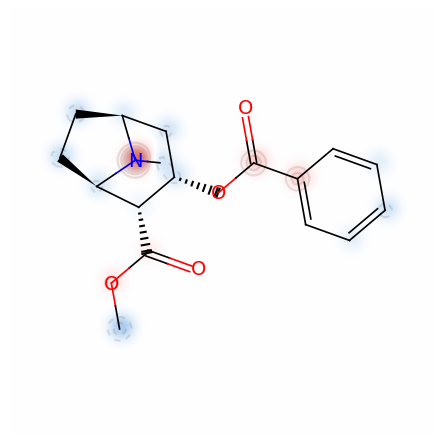

(None,
 tensor([0.6347, 3.1421, 0.7421, 0.5329, 0.5148, 0.6446, 0.8666, 0.6455, 0.6455,
         1.0798, 1.8064, 0.9614, 1.7185, 1.0062, 0.7691, 0.6086, 0.7691, 1.0062,
         1.2682, 0.9850, 1.3831, 0.2695]))

In [9]:
# Show important substructures
visualize_attention(smiles, corrected_attention), mol_attention1_after.sum(axis=0)

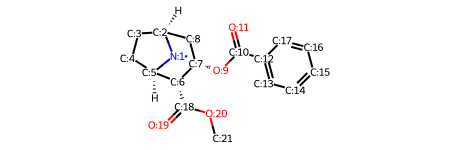

In [10]:
# Check atom index
mol_with_atom_index(m)

In [16]:
important_substuctures = [[0,1]]

# Calculate shapley values.
calc_subgraphs_shapley(reg_model_mat, single_data, important_substuctures, value_func_pred)

{(0, 1): -0.4815476246519833}

In [12]:
# Let's the contribution of aromatic Cl
smiles = "CN1[C@H]2CC[C@@H]1[C@H]([C@H](C2)OC(=O)C3=CC=CC=C3)C(=O)OC"

# Create single input to the model
single_data = create_single_data(smiles)
n_atom = single_data.x.shape[0]
m = Chem.MolFromSmiles(smiles)

# Corrected attention
corrected_attention = calculate_overall_att(single_data.x, single_data.edge_index, single_data.edge_attr, single_data.batch, reg_model_mat, n_atom)

<Figure size 2400x1800 with 0 Axes>

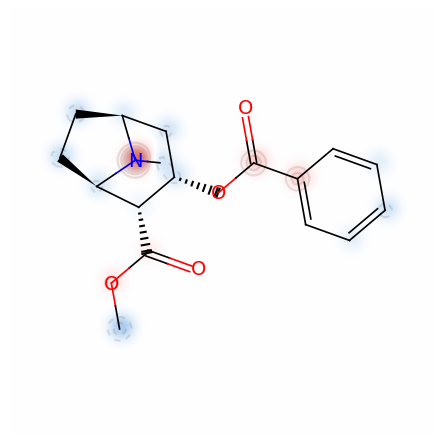

(None,
 tensor([0.6347, 3.1421, 0.7421, 0.5329, 0.5148, 0.6446, 0.8666, 0.6455, 0.6455,
         1.0798, 1.8064, 0.9614, 1.7185, 1.0062, 0.7691, 0.6086, 0.7691, 1.0062,
         1.2682, 0.9850, 1.3831, 0.2695]))

In [13]:
# Show important substructures
visualize_attention(smiles, corrected_attention), mol_attention1_after.sum(axis=0)

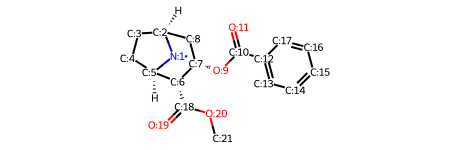

In [14]:
mol_with_atom_index(m)

In [15]:
important_substuctures = [[9,8,0]]

# Calculate shapley values
calc_subgraphs_shapley(reg_model_mat, single_data, important_substuctures, value_func_pred)

{(9, 8, 0): -0.00806420412274416}